In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from psmiles import PolymerSmiles as PS
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import matplotlib.pyplot as plt

random_seed = 123
torch.manual_seed(random_seed)
np.random.seed(random_seed)

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_pickle("../data/updated_polymers.pth")

In [3]:
scalar = MinMaxScaler()
data = df["fingerprint_circular"]
target = df["Egc"]

# Scaling target variable
target = scalar.fit_transform(target.values.reshape(-1, 1))
target_test = scalar.transform(target)

# Creating tensors from data
#Testing Data

data_test_tensor = torch.tensor(data.reset_index(drop= True), dtype=torch.float32)
target_test_tensor = torch.tensor(target_test, dtype=torch.float32)

test_dataset = TensorDataset(data_test_tensor, target_test_tensor)
test_loader = DataLoader(test_dataset, shuffle= False)


/tmp/ipykernel_3534490/4265924987.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data_test_tensor = torch.tensor(data.reset_index(drop= True), dtype=torch.float32)


In [4]:
class MTmodel(nn.Module):
    def __init__(self):
        super(MTmodel, self).__init__()
        self.my_layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(2048, 1888),
                nn.Dropout(0.296708814),
                nn.PReLU()
            ),
            nn.Sequential(
                nn.Linear(1888, 416),
                nn.Dropout(0.103316943),
                nn.PReLU()
            ),
            nn.Sequential(
                nn.Linear(416, 1632),
                nn.Dropout(0.178598433),
                nn.PReLU()
            ),
            
            nn.Linear(1632, 1)
        ])
        #self.float()
    
    def forward(self, x):
        for layer_step in self.my_layers:
            x = layer_step(x)
        return x

In [5]:
net = MTmodel()

state_dict = torch.load('../models/molecule_circular.pth')

net.load_state_dict(state_dict, strict=False)
net = net.to(DEVICE)

mse: 6.45740365844559, rmse: 2.5411421956367555, r2_score: -1.0542313099276441


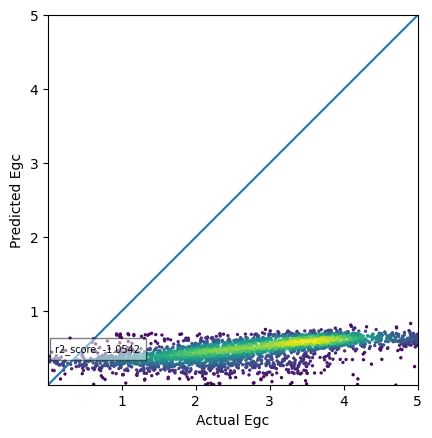

In [6]:
# Plot predictions vs. true values
from scipy.stats import gaussian_kde


@torch.no_grad()
def graphPredictions(model, data_loader , minValue, maxValue):
    
    model.eval()                               # Set the model to inference mode

    predictions=[]                             # Track predictions
    actual=[]                                  # Track the actual labels
    model = model.to(DEVICE)
    

    for (data, target) in test_loader:

        # Single forward pass
        data, target =  data.to(DEVICE), target.to(DEVICE)
        pred = model(data)
                                     
        
        # Un-normalize our prediction
        pred = scalar.inverse_transform(pred.cpu().numpy())
        pred = torch.from_numpy(pred).to(DEVICE)
        target_cpu = scalar.inverse_transform(target.cpu().numpy())
        act = torch.from_numpy(target_cpu).to(DEVICE)
        

        # Save prediction and actual label
        predictions.append(tensor.cpu().item() for tensor in pred)
        actual.append(tensor.cpu().item() for tensor in act)

    pred_list = [item for sublist in predictions for item in sublist]
    act_list = [item for sublist in actual for item in sublist]
    
    #actual_array = np.squeeze(np.array(actual))
    mse = mean_squared_error(pred_list, act_list)
    rmse = mean_squared_error(pred_list, act_list, squared = False)
    r2 = r2_score(pred_list, act_list)
    print(f"mse: {mse}, rmse: {rmse}, r2_score: {r2}")

    
    
    # Plot actuals vs predictions
    
    xy = np.vstack([pred_list,act_list])
    z = gaussian_kde(xy)(xy)
    
    plt.scatter(pred_list, act_list, c=z, s=2)
    plt.xlabel('Actual Egc')
    plt.ylabel('Predicted Egc')
    plt.plot([minValue,maxValue], [minValue,maxValue])
    plt.xlim(minValue, maxValue)
    plt.ylim(minValue, maxValue)

    # Make the display equal in both dimensions
    plt.gca().set_aspect('equal', adjustable='box')
    text_x = 0.1
    text_y = 0.45
    plt.text(text_x, text_y, f"r2_score: {round(r2, 4)}", fontsize=7, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()


graphPredictions(net, test_loader, 0.005, 5)